In [1]:
# !pip install emoji§

In [ ]:
# utils
import pandas as pd
import seaborn as sns
import numpy as np
import emoji
import string
import nltk
from nltk.corpus import stopwords
import spacy
import re
import time

from sklearn.model_selection import train_test_split

# vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble  import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from collections import defaultdict

# lime implementation
from tqdm import tqdm
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('fakeWhatsApp.BR_2018.csv')
df

/var/folders/jc/ggdhgrys23xgcrxc0fly4jjc0000gn/T/ipykernel_1346/3847491229.py:1: DtypeWarning: Columns (4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('fakeWhatsApp.BR_2018.csv')


,id,date,hour,timestamp,ddi,country,country_iso3,ddd,state,group,midia,url,characters,words,types,viral,shares,text,misinformation
0,3631133147603888180,01/08/18,13:13,2018-08-01 13:13:00,55,BRASIL,BRA,17,São Paulo,2018_1,1,0,25,4,4,0,1,<Arquivo de mídia oculto>,-1
1,3631133147603888180,01/08/18,13:24,2018-08-01 13:24:00,55,BRASIL,BRA,17,São Paulo,2018_1,0,0,58,9,9,1,2,O Bolsonaro tem que estar preparado pra respon...,-1
2,3631133147603888180,01/08/18,13:24,2018-08-01 13:24:00,55,BRASIL,BRA,17,São Paulo,2018_1,1,0,25,4,4,0,1,<Arquivo de mídia oculto>,-1
3,-4391661641377612003,01/08/18,13:28,2018-08-01 13:28:00,55,BRASIL,BRA,13,São Paulo,2018_1,0,0,5,1,1,0,1,Boaaa,-1
4,-4391661641377612003,09/08/18,14:46,2018-08-09 14:46:00,55,BRASIL,BRA,13,São Paulo,2018_1,1,0,25,4,4,0,1,<Arquivo de mídia oculto>,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282596,-3459365403520904542,28/10/18,21:48,2018-10-28 21:48:00,?,?,?,?,?,2018_59,1,0,25,4,4,0,1,<Arquivo de mídia oculto>,-1
282597,-3459365403520904542,28/10/18,22:06,2018-10-28 22:06:00,?,?,?,?,?,2018_59,1,0,25,4,4,0,1,<Arquivo de mídia oculto>,-1
282598,-3459365403520904542,28/10/18,22:08,2018-10-28 22:08:00,?,?,?,?,?,2018_59,1,0,25,4,4,0,1,<Arquivo de mídia oculto>,-1
282599,-3459365403520904542,28/10/18,22:12,2018-10-28 22:12:00,?,?,?,?,?,2018_59,1,0,25,4,4,0,1,<Arquivo de mídia oculto>,-1


- Only viral menssages from non midiatic sources

In [4]:
df = df[df['viral'] == 1]
df = df[df['midia'] == 0]

- We came from 282601 rows to 20872

In [5]:
print(df.head)

<bound method NDFrame.head of                          id      date   hour            timestamp ddi country  \
1       3631133147603888180  01/08/18  13:24  2018-08-01 13:24:00  55  BRASIL   
15      3631133147603888180  10/08/18  14:31  2018-08-10 14:31:00  55  BRASIL   
26     -4391661641377612003  11/08/18  19:28  2018-08-11 19:28:00  55  BRASIL   
43      3631133147603888180  15/08/18  19:23  2018-08-15 19:23:00  55  BRASIL   
103    -4391661641377612003  22/08/18  22:11  2018-08-22 22:11:00  55  BRASIL   
...                     ...       ...    ...                  ...  ..     ...   
282555   807720138466692852  28/10/18  01:00  2018-10-28 01:00:00   ?       ?   
282556 -8115822708746651359  28/10/18  01:01  2018-10-28 01:01:00   ?       ?   
282558   807720138466692852  28/10/18  02:07  2018-10-28 02:07:00   ?       ?   
282564   807720138466692852  28/10/18  06:42  2018-10-28 06:42:00   ?       ?   
282565   807720138466692852  28/10/18  07:40  2018-10-28 07:40:00   ?       ?  

- Elimination of data there was classified with misinformation = -1

In [6]:
df = df[df["misinformation"] != -1]

- Looking the data

- Misinformation

In [7]:
i = 0
for message in df[df['misinformation'] == 1]['text'].sample(5):
    print(f"Mensagem: {i}\n")
    print(message)
    print("\n")
    i+=1

Mensagem: 0

Olha o eleitor do Bolsonaro que foi xingar o Haddad na Missa - nota do PT. Na verdade, é um petista passando por eleitor do Bolsonaro. 
E Gérson Florindo, Presidente do PT de Ubatuba - SP. 
Só tem canalhas nesse partido! Não salva um 😡😡😡


Mensagem: 1

A cirurgía custa R$ 18.000,00. Deve ser feita o quanto antes. Ela tem pouco tempo de vida. Não pode esperar pelo SUS. O Whatsapp vai pagar R$ 1,00 cada vez que a MSG fôr repassada.  Vamos salvar a vida dessa criança! 😇🙏


Mensagem: 2

Prefiro ser revistado em cada esquina do que ser assaltado em cada quarteirão, prefiro o militar pedindo meu documento do que o bandido levando minha carteira, prefiro a incerteza da mudança do que a certeza da mesmice, prefiro o braço forte dos honestos do que as mãos frouxas dos corruptos. É por isso que eu voto 17 Bolsonaro! 🇧🇷


Mensagem: 3

RARIDADE:

Esta foto é do julgamento de uma jovem de classe média alta responsável pelo assalto ao Banco Banespa da  Rua Iguatemi, em São Paulo, ocorri

- Non misinformation

In [8]:
i = 0
for message in df[df['misinformation'] == 0]['text'].sample(5):
    print(f"Mensagem: {i}\n")
    print(message)
    print("\n")
    i+=1

Mensagem: 0

A PEC que congela os gastos com educação, saúde, transporte, etc já foi aprovada e esse ano estamos vendo seus reflexos. Em 2016 vários estudantes foram às Universidades protestar CONTRA essa PEC da morte e foram apontados como baderneiros, vândalos, etc. É, hoje é possível enxergar quem estava coerente àquela época e quem não estava. Que esse ano nós, cidadãos, estejamos bem conscientes na hora de votar, essas eleições definirão o rumo do país.


Mensagem: 1

Bolsonaro 5 mil votos Haddad 200 votos resultado no Japão 🇯🇵


Mensagem: 2

Vcs são *BOLSONARO RAIZ ?!*

Desafio do dia 👇👇👇👇👇

Vamos tocar onde a ferida dói !!!
Negativem as propagandas da lacradora CLÁUDIA LEITE, direto nos links dos patrocinadores !!!

https://youtu.be/diTC1gv9RbQ

https://youtu.be/9euz7r2aj9g

https://youtu.be/FytEcPwDO_4

https://youtu.be/arSKQ73vMPE

https://youtu.be/08u6PI9-03w

https://youtu.be/KZ67pgJIS0s

https://youtu.be/97MkFCCNacU

https://youtu.be/7q_whjCx9X0


Mensagem: 3

Realmente não

- Corpus statistics

In [9]:
df.describe()[['characters','words','shares']]

,characters,words,shares
count,18951.000000,18951.000000,18951.000000
mean,574.501293,87.253390,11.885230
std,929.443834,142.718198,16.573243
min,38.000000,10.000000,2.000000
25%,132.000000,19.000000,2.000000
50%,222.000000,33.000000,5.000000
75%,551.000000,85.000000,13.000000
max,15683.000000,2664.000000,91.000000


- Removing duplicates

In [10]:
df = df.drop_duplicates(subset=['text'])

- Definition of X and y

In [11]:
texts = df[df['midia'] == 0]['text']
y = df[df['midia'] == 0]['misinformation']

data after remove duplicates


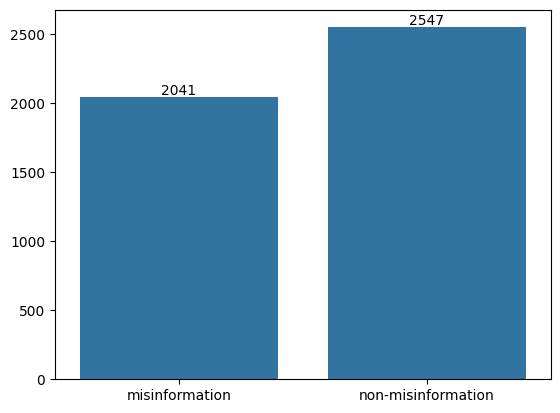

In [12]:
print('data after remove duplicates')
pos_mask = y == 1
pos = y[pos_mask]
neg_mask = y == 0
neg = y[neg_mask]
values = [pos.shape[0],neg.shape[0]]
keys = ['misinformation', 'non-misinformation']
g = sns.barplot(x = keys, y = values)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2.,
                                               p.get_height()), ha = 'center',
               va = 'center', xytext = (0, 5), textcoords = 'offset points')

- Lenght of the data used

In [13]:
print(len(texts))
print(len(y))

4588
4588


- Misinformation column statistics

In [14]:
df.columns

Index(['id', 'date', 'hour', 'timestamp', 'ddi', 'country', 'country_iso3',
       'ddd', 'state', 'group', 'midia', 'url', 'characters', 'words', 'types',
       'viral', 'shares', 'text', 'misinformation'],
      dtype='object')

In [15]:
def avgSizeWords(string):
     list_string = string.split()
     chars = np.array([len(s) for s in list_string])
     return chars.mean()
df['types'] = [len(set(t.split())) for t in df['text']]
df['types/token ratio'] = df['types']/df['words']
df['char/word ratio'] = df['characters']/df['words']
df['average chars by word'] = [avgSizeWords(t) for t in df['text']]

In [16]:
mis = df[df['misinformation']==1][['words','types','types/token ratio' ,'characters', 'char/word ratio', 'average chars by word','shares']].mean().to_frame().rename(columns={0: "misinformation"})
non_mis = df[df['misinformation']==0][['words','types','types/token ratio' ,'characters', 'char/word ratio', 'average chars by word','shares']].mean().to_frame().rename(columns={0: "non-misinformation"})
mis.join(non_mis, lsuffix='_misinformation', rsuffix='_non-misinformation')

,misinformation,non-misinformation
words,113.870652,60.044366
types,78.719255,44.574401
types/token ratio,0.845943,0.899166
characters,719.406663,408.918728
char/word ratio,6.590809,7.231410
average chars by word,5.529126,6.174667
shares,4.974032,3.454653


- Train/Test split

In [17]:
texts_train, texts_test, y_train, y_test = train_test_split(texts,y,test_size=0.2,stratify=y,random_state=42)

- Pre-processing

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/miguelmauricioantonio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
# !python -m spacy download pt_core_news_sm

In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/miguelmauricioantonio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
#emojis and punctuation
emojis_list = list(emoji.EMOJI_DATA.keys())
emojis_list += ['\n']
punct = list(string.punctuation) + ['\n']
emojis_punct = emojis_list + punct

def processEmojisPunctuation(text, remove_punct = False, remove_emoji = False):
    '''
    Put spaces between emojis. Removes punctuation.
    '''
    #get all unique chars
    chars = set(text)
    #for each unique char in text, do:
    for c in chars:

        if remove_punct: #remove punctuation
            if c in punct:
                text = text.replace(c, ' ')
        else: #put spaces between punctuation
            if c in punct:
                text = text.replace(c, ' ' + c + ' ')

        if remove_emoji: #remove emojis
            if c in emojis_list:
                text = text.replace(c, ' ')
        else: #put spaces between emojis
            if c in emojis_list:
                text = text.replace(c, ' ' + c + ' ')

    text = re.sub(' +', ' ', text)
    return text

#stop words removal
stop_words = list(stopwords.words('portuguese'))
new_stopwords = ['aí','pra','vão','vou','onde','lá','aqui',
                 'tá','pode','pois','so','deu','agora','todo',
                 'nao','ja','vc', 'bom', 'ai','ta', 'voce', 'alguem', 'ne', 'pq',
                 'cara','to','mim','la','vcs','tbm', 'tudo']
stop_words = stop_words + new_stopwords
final_stop_words = []
for sw in stop_words:
    sw = ' '+ sw + ' '
    final_stop_words.append(sw)

def removeStopwords(text):
    for sw in final_stop_words:
        text = text.replace(sw,' ')
    text = re.sub(' +',' ',text)
    return text

#lemmatization
nlp = spacy.load('pt_core_news_sm')
def lemmatization(text):
    doc = nlp(text)
    for token in doc:
        if token.text != token.lemma_:
            text = text.replace(token.text, token.lemma_)
    return text


def domainUrl(text):
    '''
    Substitutes an URL in a text for the domain of this URL
    Input: an string
    Output: the string with the modified URL
    '''
    if 'http' in text:
        re_url = '[^\s]*https*://[^\s]*'
        matches = re.findall(re_url, text, flags=re.IGNORECASE)
        for m in matches:
            domain = m.split('//')
            domain = domain[1].split('/')[0]
            text = re.sub(re_url, domain, text, 1)
        return text
    else:
        return text

def processLoL(text):
    re_kkk = 'kkk*'
    t = re.sub(re_kkk, "kkk", text, flags=re.IGNORECASE)
    return t

def firstSentence(text):
    list_s = re.split('; |\. |\! |\? |\n',text)
    for s in list_s:
        if s is not None:
            return s


def preprocess(text,semi=False, rpunct = False, remoji = False, sentence = False):
    if sentence:
        text = firstSentence(text) # remove
    text = text.lower().strip()
    text = domainUrl(text)
    text = processLoL(text)
    text = processEmojisPunctuation(text,remove_punct = rpunct, remove_emoji=remoji)
    if semi:
        return text
    text = removeStopwords(text)
    text = lemmatization(text)
    return text


<>:68: SyntaxWarning: invalid escape sequence '\s'
<>:84: SyntaxWarning: invalid escape sequence '\.'
<>:68: SyntaxWarning: invalid escape sequence '\s'
<>:84: SyntaxWarning: invalid escape sequence '\.'
/var/folders/jc/ggdhgrys23xgcrxc0fly4jjc0000gn/T/ipykernel_1346/1358206803.py:68: SyntaxWarning: invalid escape sequence '\s'
  re_url = '[^\s]*https*://[^\s]*'
/var/folders/jc/ggdhgrys23xgcrxc0fly4jjc0000gn/T/ipykernel_1346/1358206803.py:84: SyntaxWarning: invalid escape sequence '\.'
  list_s = re.split('; |\. |\! |\? |\n',text)


In [22]:
texts = df['pre_processed_text'] = [preprocess(t, sentence = True) for t in texts]

/var/folders/jc/ggdhgrys23xgcrxc0fly4jjc0000gn/T/ipykernel_1346/1358206803.py:73: DeprecationWarning: 'count' is passed as positional argument
  text = re.sub(re_url, domain, text, 1)


- Only retain one hundred words for each text

In [23]:
def trucateText(text):
    words = text.split()
    if len(words) <= 100:
        return text
    else:
        words = words[0:100]
        text = ' '.join(words)
        return text

In [24]:
texts = [trucateText(t) for t in texts]

- Vectorization

In [25]:
vectorization = ['tfidf-']
ngrams = ['unigram_bigram_trigram']
processed = ['-pre_processed']
max_features = ['']#,'-max_features']
balancing = ['-oversampling']
experiments = []

for vec in vectorization:
    for ng in ngrams:
        for p in processed:
            for m in max_features:
                exp = vec+ng+p+m
                experiments.append(exp)

print(len(experiments))
experiments


1


['tfidf-unigram_bigram_trigram-pre_processed']

In [26]:
def defineVectorizing(experiment):
    max_feat = None
    # maximum number of features
    if 'max_features' in experiment:
        max_feat = 5000
    exp_parts = experiment.split('-')
    vec = exp_parts[0]
    ngram = exp_parts[1]
    # ngram
    if ngram == 'unigram':
        ng = (1,1)
    elif ngram == 'unigram_bigram':
        ng = (1,2)
    elif ngram == 'unigram_bigram_trigram':
        ng = (1,3)
    # vectorizer
    if vec == 'bow':
        vectorizer = CountVectorizer(max_features = max_feat, binary=True, ngram_range = ng, lowercase = False, token_pattern = r'[^\s]+')
    elif vec == 'tfidf':
        vectorizer = TfidfVectorizer(max_features = max_feat, ngram_range = ng, lowercase = False, token_pattern = r'[^\s]+')

    return vectorizer

def vectorizing(vectorizer,texts_train,texts_test):
    vectorizer.fit(texts_train) # learns the vocabulary
    X_train = vectorizer.transform(texts_train) # converts new text into vectors using the learning vocabulary
    X_test = vectorizer.transform(texts_test)
    #print('Train:',X_train.shape)
    #print('Test:',X_test.shape)
    return X_train, X_test

vectorizer = defineVectorizing(experiments[0])
X_train,X_test = vectorizing(vectorizer,texts_train,texts_test)

- Models Train and Test

In [27]:
models = ['lr','nb','lsvm','sgd', 'svm', 'knn', 'rf', 'gb', 'mlp']
print(len(models))
models

9


['lr', 'nb', 'lsvm', 'sgd', 'svm', 'knn', 'rf', 'gb', 'mlp']

In [28]:
def getTestMetrics(y_true, y_pred, y_prob=None, full_metrics=False):
    # Importar funções sklearn com apelidos locais
    from sklearn.metrics import (
        accuracy_score as sk_accuracy,
        precision_score as sk_precision,
        recall_score as sk_recall,
        f1_score as sk_f1,
        roc_auc_score as sk_roc_auc
    )
    import numpy as np

    acc = sk_accuracy(y_true, y_pred)
    precision = sk_precision(y_true, y_pred, average='macro')
    recall = sk_recall(y_true, y_pred, average='macro')
    f1 = sk_f1(y_true, y_pred, average='macro')

    try:
        roc_auc = sk_roc_auc(y_true, y_prob, multi_class='ovr')
    except Exception:
        roc_auc = np.nan

    # placeholders para compatibilidade
    precision_neg = recall_neg = f1_neg = np.nan

    if full_metrics:
        print(f"Accuracy: {acc:.3f}")
        print(f"Precision (macro): {precision:.3f}")
        print(f"Recall (macro): {recall:.3f}")
        print(f"F1 (macro): {f1:.3f}")
        print(f"AUC: {roc_auc:.3f}")

    return acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc


In [29]:
def lr_eval(X_train, y_train, X_test, y_test):
    print('=== Logistic Regression ===')
    logreg = LogisticRegression().fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    y_prob = logreg.predict_proba(X_test)[:, 1]
    metrics = getTestMetrics(y_test, y_pred, y_prob, full_metrics=True)
    return logreg, metrics


def nb_eval(X_train, y_train, X_test, y_test):
    if 'bow' in experiments[0]:
        print('=== Bernoulli Naive-Bayes ===')
        nb = BernoulliNB().fit(X_train, y_train)
    elif 'tfidf' in experiments[0]:
        print('=== Complement Naive-Bayes ===')
        nb = ComplementNB().fit(X_train, y_train)
    else:
        nb = BernoulliNB().fit(X_train, y_train)
    y_pred = nb.predict(X_test)
    y_prob = nb.predict_proba(X_test)[:, 1]
    metrics = getTestMetrics(y_test, y_pred, y_prob, full_metrics=True)
    return nb, metrics


def lsvm_eval(X_train, y_train, X_test, y_test):
    print('=== Linear Support Vector Machine ===')
    svm = LinearSVC(dual=False).fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    metrics = getTestMetrics(y_test, y_pred, full_metrics=True)
    return svm, metrics


def sgd_eval(X_train, y_train, X_test, y_test):
    print('=== Linear SVM with SGD training ===')
    sgd = SGDClassifier().fit(X_train, y_train)
    y_pred = sgd.predict(X_test)
    metrics = getTestMetrics(y_test, y_pred, full_metrics=True)
    return sgd, metrics


def svm_eval(X_train, y_train, X_test, y_test):
    print('=== SVM with RBF kernel ===')
    svc = SVC(probability=True).fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    y_prob = svc.predict_proba(X_test)[:, 1]
    metrics = getTestMetrics(y_test, y_pred, y_prob, full_metrics=True)
    return svc, metrics


def knn_eval(X_train, y_train, X_test, y_test):
    print('=== KNN ===')
    knn = KNeighborsClassifier(weights='distance', n_jobs=-1).fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    y_prob = knn.predict_proba(X_test)[:, 1]
    metrics = getTestMetrics(y_test, y_pred, y_prob, full_metrics=True)
    return knn, metrics


def rf_eval(X_train, y_train, X_test, y_test):
    print('=== Random Forest ===')
    rf = RandomForestClassifier(n_jobs=-1).fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]
    metrics = getTestMetrics(y_test, y_pred, y_prob, full_metrics=True)
    return rf, metrics


def gb_eval(X_train, y_train, X_test, y_test):
    print('=== Gradient Boosting ===')
    gb = GradientBoostingClassifier(n_estimators=200).fit(X_train, y_train)
    y_pred = gb.predict(X_test)
    y_prob = gb.predict_proba(X_test)[:, 1]
    metrics = getTestMetrics(y_test, y_pred, y_prob, full_metrics=True)
    return gb, metrics


def mlp_eval(X_train, y_train, X_test, y_test):
    print('=== Multilayer Perceptron ===')
    mlp = MLPClassifier(
        verbose=True, early_stopping=True,
        batch_size=64, n_iter_no_change=5, tol=1e-3
    ).fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    y_prob = mlp.predict_proba(X_test)[:, 1]
    metrics = getTestMetrics(y_test, y_pred, y_prob, full_metrics=True)
    return mlp, metrics


def model_eval(model, X_train, y_train, X_test, y_test):
    if model == 'lr':
        return lr_eval(X_train, y_train, X_test, y_test)
    elif model == 'nb':
        return nb_eval(X_train, y_train, X_test, y_test)
    elif model == 'lsvm':
        return lsvm_eval(X_train, y_train, X_test, y_test)
    elif model == 'sgd':
        return sgd_eval(X_train, y_train, X_test, y_test)
    elif model == 'svm':
        return svm_eval(X_train, y_train, X_test, y_test)
    elif model == 'knn':
        return knn_eval(X_train, y_train, X_test, y_test)
    elif model == 'rf':
        return rf_eval(X_train, y_train, X_test, y_test)
    elif model == 'gb':
        return gb_eval(X_train, y_train, X_test, y_test)
    elif model == 'mlp':
        return mlp_eval(X_train, y_train, X_test, y_test)
    else:
        raise ValueError(f"Modelo '{model}' não reconhecido.")

In [30]:
lr = model_eval('lr',X_train,y_train,X_test,y_test)
nb = model_eval('nb',X_train,y_train,X_test,y_test)
lsvm = model_eval('lsvm',X_train,y_train,X_test,y_test)
sgd = model_eval('sgd',X_train,y_train,X_test,y_test)
knn = model_eval('knn',X_train,y_train,X_test,y_test)
rf = model_eval('rf',X_train,y_train,X_test,y_test)
#gb = model_eval('gb',X_train,y_train,X_test,y_test)
#mlp = model_eval('mlp',X_train,y_train,X_test,y_test)

=== Logistic Regression ===
Accuracy: 0.710
Precision (macro): 0.709
Recall (macro): 0.712
F1 (macro): 0.709
AUC: 0.790
=== Complement Naive-Bayes ===
Accuracy: 0.719
Precision (macro): 0.752
Recall (macro): 0.737
F1 (macro): 0.717
AUC: 0.854
=== Linear Support Vector Machine ===
Accuracy: 0.747
Precision (macro): 0.753
Recall (macro): 0.755
F1 (macro): 0.747
AUC: nan
=== Linear SVM with SGD training ===
Accuracy: 0.739
Precision (macro): 0.745
Recall (macro): 0.747
F1 (macro): 0.739
AUC: nan
=== KNN ===
Accuracy: 0.698
Precision (macro): 0.694
Recall (macro): 0.693
F1 (macro): 0.694
AUC: 0.771
=== Random Forest ===
Accuracy: 0.721
Precision (macro): 0.751
Recall (macro): 0.697
F1 (macro): 0.695
AUC: 0.816


In [31]:
print(lr[0])
print(lr[1])

LogisticRegression()
(0.710239651416122, 0.7092307692307692, nan, 0.7117647058823529, nan, 0.7089965249474453, nan, 0.7899653979238754)


# Experiences

## Experience 1 - Generating LIME explanations for each model predictions and compared the words that appear the most

In [32]:
# !pip install lime

LIME object stores: weights, class probabilities, raw scores, and links back to the original text.

In [33]:
def explain_with_lime(model, vectorizer, texts, idx):
    explainer = LimeTextExplainer(class_names=["real", "fake"])

    if hasattr(texts,"iloc"):
      text_instance = texts.iloc[idx]
    else:
      text_instance = texts[idx]

    def predict_proba(texts_list):
        X = vectorizer.transform(texts_list)
        if hasattr(model, "predict_proba"):
            return model.predict_proba(X)
        else:
            scores = model.decision_function(X)
            if scores.ndim == 1:
                scores = np.vstack([-scores, scores]).T
            probs = np.exp(scores) / np.exp(scores).sum(axis=1, keepdims=True)
            return probs

    print(f"\nTexto: {text_instance}")
    print("Classe prevista:", model.predict(vectorizer.transform([text_instance]))[0])
    exp = explainer.explain_instance(text_instance, predict_proba, num_features=10)
    exp.show_in_notebook(text=True)
    return exp


trained_models = {
    "LogisticRegression": lr,
    "MultinomialNB": nb,
    "LinearSVC": lsvm,
    "SGDClassifier": sgd,
    "KNN": knn,
    "RandomForest": rf
    #"GradientBoosting": gb,
    #"MLP": mlp
}

idx = 200
for name, model_tuple in trained_models.items():
    print(f"\nModel: {name}")
    try:
        model = model_tuple[0] if isinstance(model_tuple, tuple) else model_tuple
        exp = explain_with_lime(model,vectorizer,texts_test,idx)
    except Exception as e:
        print(f"Erro com {name}: {e}")



Model: LogisticRegression

Texto: Liguei para o Diretório do PT ofercendo ajuda.....
Acabei desistindo. Eita "povinho mal educado!!😱😱
Classe prevista: 0
Erro com LogisticRegression: cannot import name 'display' from 'IPython.core.display' (/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/IPython/core/display.py)

Model: MultinomialNB

Texto: Liguei para o Diretório do PT ofercendo ajuda.....
Acabei desistindo. Eita "povinho mal educado!!😱😱
Classe prevista: 1
Erro com MultinomialNB: cannot import name 'display' from 'IPython.core.display' (/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/IPython/core/display.py)

Model: LinearSVC

Texto: Liguei para o Diretório do PT ofercendo ajuda.....
Acabei desistindo. Eita "povinho mal educado!!😱😱
Classe prevista: 1
Erro com LinearSVC: cannot import name 'display' from 'IPython.core.display' (/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/IPython/core/di

In [34]:
trained_models.items()

dict_items([('LogisticRegression', (LogisticRegression(), (0.710239651416122, 0.7092307692307692, nan, 0.7117647058823529, nan, 0.7089965249474453, nan, 0.7899653979238754))), ('MultinomialNB', (ComplementNB(), (0.7189542483660131, 0.7519329896907216, nan, 0.736764705882353, nan, 0.7172147001934236, nan, 0.8538927335640137))), ('LinearSVC', (LinearSVC(dual=False), (0.7472766884531591, 0.7534016205473169, nan, 0.7549019607843137, nan, 0.7472178966158989, nan, nan))), ('SGDClassifier', (SGDClassifier(), (0.738562091503268, 0.7454832535885167, nan, 0.7465686274509804, nan, 0.7385310648640437, nan, nan))), ('KNN', (KNeighborsClassifier(n_jobs=-1, weights='distance'), (0.6982570806100218, 0.6942979254195332, nan, 0.6931372549019608, nan, 0.6936147140507618, nan, 0.7710544021530181))), ('RandomForest', (RandomForestClassifier(n_jobs=-1), (0.7211328976034859, 0.7509597046310332, nan, 0.6973039215686274, nan, 0.6951511220651188, nan, 0.8159674163783159)))])

In [35]:
# return the common words between models and show the word weight
def compare_lime_words(trained_models, vectorizer, texts, idx):

    words_by_model = {} # {word1:[(model1],"fake",weight1),(model2,"fake",weight2)}

    for name, model_tuple in trained_models.items():
        try:
            if isinstance(model_tuple,tuple):
              model = model_tuple[0]
            else:
              model = model_tuple
            exp = explain_with_lime(model,vectorizer,texts,idx)
            words = exp.as_list() # return a [(word1,weight1),(word2,weight2),...]

            for w,weight in words:
              # fake is 1 and real is 0
              if weight > 0:
                assign = "fake"
              else:
                assign = "real"
              if w not in words_by_model:
                words_by_model = []
              words_by_model[w].append((name,assign,abs(weight)))

        except Exception:
            pass

    # to keep only the words that are on multiple models
    shared_words = {}
    for w,info in words_by_model.items():
      if len(info) > 1:
        shared_words[w] = info

    if not shared_words:
        return pd.DataFrame(columns=["word","avg_weight"])

    rows = []
    for word,infos in shared_words.items():
        avg_weight = np.mean([x[2] for x in infos])
        directions = {x[0]: x[1] for x in infos}  # builds the direction of the word (fake or real)
        rows.append({"word":word, "avg_weight":avg_weight, **directions})

    df = pd.DataFrame(rows).sort_values("avg_weight", ascending=False).fillna("-")
    return df


idx = 200  # sentence that will be analyzed
df_common = compare_lime_words(trained_models,vectorizer,texts_test,idx)
df_common



Texto: Liguei para o Diretório do PT ofercendo ajuda.....
Acabei desistindo. Eita "povinho mal educado!!😱😱
Classe prevista: 0

Texto: Liguei para o Diretório do PT ofercendo ajuda.....
Acabei desistindo. Eita "povinho mal educado!!😱😱
Classe prevista: 1

Texto: Liguei para o Diretório do PT ofercendo ajuda.....
Acabei desistindo. Eita "povinho mal educado!!😱😱
Classe prevista: 1

Texto: Liguei para o Diretório do PT ofercendo ajuda.....
Acabei desistindo. Eita "povinho mal educado!!😱😱
Classe prevista: 1

Texto: Liguei para o Diretório do PT ofercendo ajuda.....
Acabei desistindo. Eita "povinho mal educado!!😱😱
Classe prevista: 0

Texto: Liguei para o Diretório do PT ofercendo ajuda.....
Acabei desistindo. Eita "povinho mal educado!!😱😱
Classe prevista: 0


,word,avg_weight


## Experience 2 - Global Approach


Generating LIME explanations for: LogisticRegression


100%|██████████| 300/300 [01:00<00:00,  4.98it/s]



Generating LIME explanations for: MultinomialNB


100%|██████████| 300/300 [01:01<00:00,  4.88it/s]



Generating LIME explanations for: LinearSVC


100%|██████████| 300/300 [00:59<00:00,  5.04it/s]



Generating LIME explanations for: SGDClassifier


100%|██████████| 300/300 [01:00<00:00,  4.99it/s]



Generating LIME explanations for: KNN


100%|██████████| 300/300 [01:52<00:00,  2.66it/s]



Generating LIME explanations for: RandomForest


100%|██████████| 300/300 [01:11<00:00,  4.21it/s]



LIME results saved.


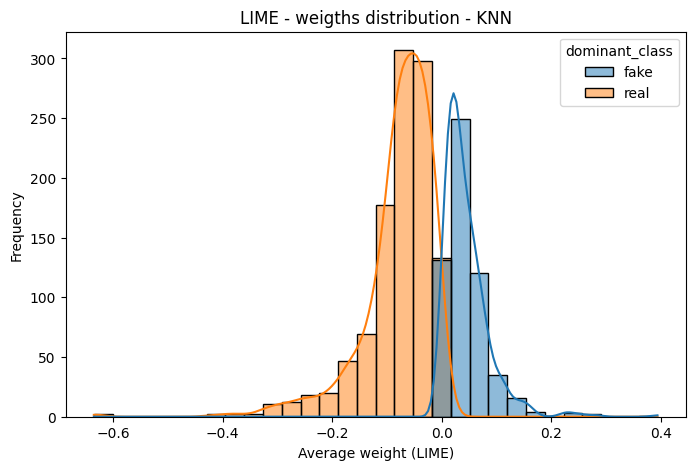


Top 10 most explicative words for Fake (KNN)


,word,avg_weight,n_occurrences
299,FAVOR,0.393354,1
1133,gravou,0.282760,1
205,Ciro,0.258346,4
724,ajude,0.245006,1
598,Sem,0.230618,2
494,POR,0.229150,1
702,acertou,0.219551,1
1325,padre,0.166709,2
692,abaixo_,0.166004,1
999,eleitores,0.161451,1



Top 10 most explicative words for REAL (KNN)


,word,avg_weight,n_occurrences
1052,evangélicas,-0.634763,1
157,Borges,-0.627096,1
134,BPM,-0.422350,1
957,diferença,-0.397233,1
733,amizades,-0.386666,1
1112,gado,-0.375213,1
736,andado,-0.358417,1
207,Civil,-0.343189,1
1126,globo,-0.325466,1
707,acontecimentos,-0.324875,1


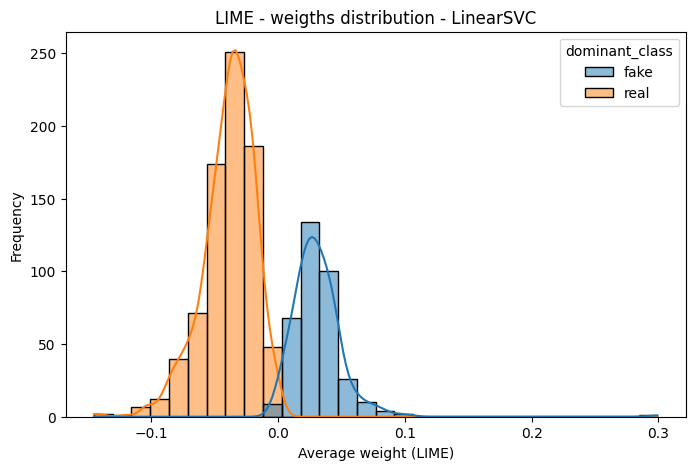


Top 10 most explicative words for Fake (LinearSVC)


,word,avg_weight,n_occurrences
2132,___________________,0.299272,2
1933,Maria,0.101971,1
2023,QUE,0.097017,13
1927,Maior,0.086374,1
2794,vídeo,0.085231,18
2785,votarem,0.078147,1
2122,Vote,0.077853,2
2764,veja,0.076919,2
2144,acertou,0.076469,1
2573,padre,0.075659,2



Top 10 most explicative words for REAL (LinearSVC)


,word,avg_weight,n_occurrences
2335,eleitorado,-0.145308,1
2699,sentiu,-0.140054,1
2720,suspende,-0.119941,1
2279,coragem,-0.105900,2
2067,Senhor,-0.105577,1
1986,PRODUÇÃO,-0.102341,1
2754,tô,-0.102192,1
2424,globo,-0.102074,1
1770,Carreata,-0.101954,1
2695,seja,-0.101565,1


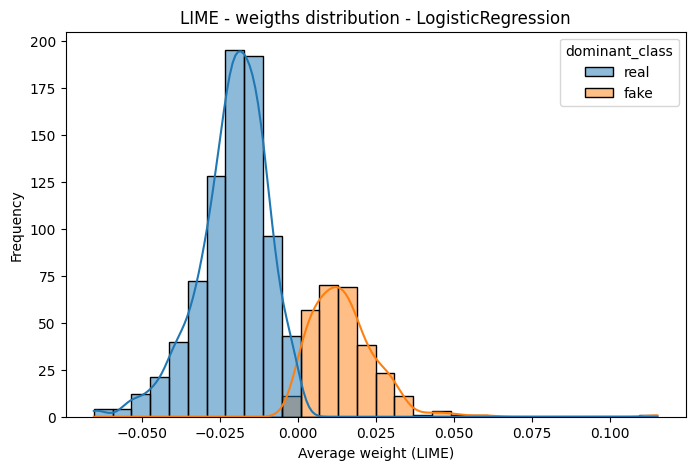


Top 10 most explicative words for Fake (LogisticRegression)


,word,avg_weight,n_occurrences
3271,___________________,0.115336,2
3170,QUE,0.059754,13
2970,Escândalo,0.050751,1
3680,o,0.047803,169
2820,2011,0.044799,1
3888,vídeo,0.043368,19
3765,que,0.039305,128
3461,e,0.035940,136
2818,2007,0.032824,1
3061,LulaValeALuta,0.032440,1



Top 10 most explicative words for REAL (LogisticRegression)


,word,avg_weight,n_occurrences
3466,eleitorado,-0.065530,1
3089,Mudança,-0.064990,1
3803,sentiu,-0.064899,1
3415,criou,-0.063030,1
3134,PRODUÇÃO,-0.056347,1
3526,final,-0.055322,1
2944,Diretório,-0.054613,1
3800,seja,-0.054349,1
3212,Senhor,-0.052802,1
3383,cidades,-0.052758,1


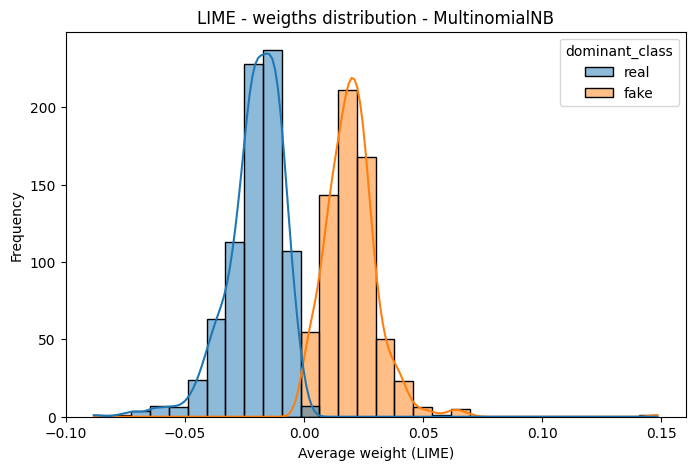


Top 10 most explicative words for Fake (MultinomialNB)


,word,avg_weight,n_occurrences
4502,___________________,0.148494,2
4510,acertou,0.068692,1
4257,Maria,0.066254,1
5068,padre,0.064121,2
4127,Escândalo,0.063614,1
5060,online,0.062302,1
4458,Trump,0.060235,1
5132,prefiro,0.053165,2
4494,Vote,0.052454,3
4252,Maior,0.052048,1



Top 10 most explicative words for REAL (MultinomialNB)


,word,avg_weight,n_occurrences
4047,Carreata,-0.088282,1
4295,O,-0.077207,1
4767,eleitorado,-0.072166,1
5256,suspende,-0.071875,1
5225,sentiu,-0.070059,1
5299,tô,-0.065230,1
4192,Hotel,-0.063579,1
4784,entrar,-0.063575,6
4083,Dep,-0.061734,2
5341,válidos,-0.061499,1


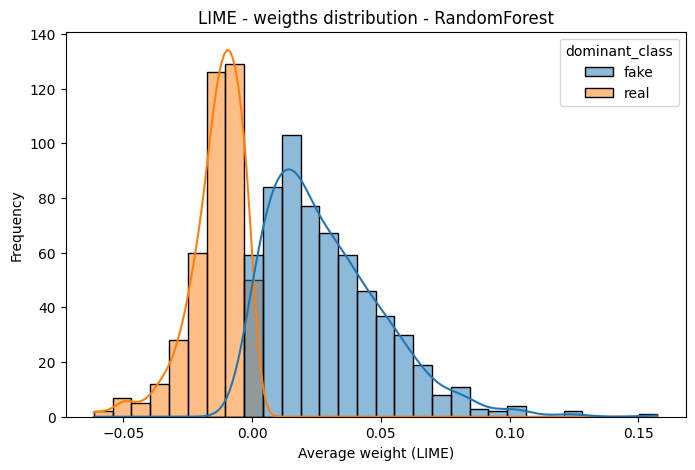


Top 10 most explicative words for Fake (RandomForest)


,word,avg_weight,n_occurrences
5749,Vote,0.157403,2
5903,dar,0.125507,1
6191,pena,0.121109,1
5939,disser,0.104498,1
5660,QUE,0.103306,13
5717,Temos,0.103171,1
6370,votarem,0.102227,1
6164,online,0.097806,1
5584,Maria,0.097026,1
6130,muitos,0.090811,1



Top 10 most explicative words for REAL (RandomForest)


,word,avg_weight,n_occurrences
6103,maldito,-0.061438,1
5893,coragem,-0.058313,2
5399,Absurdo,-0.053811,2
5480,Divulguem,-0.051791,1
5949,dó,-0.050497,1
6050,graça,-0.050356,1
5424,Brasileiros,-0.048472,1
6131,muitos,-0.047731,1
6258,resisti,-0.046974,1
6243,qualquer,-0.044022,1


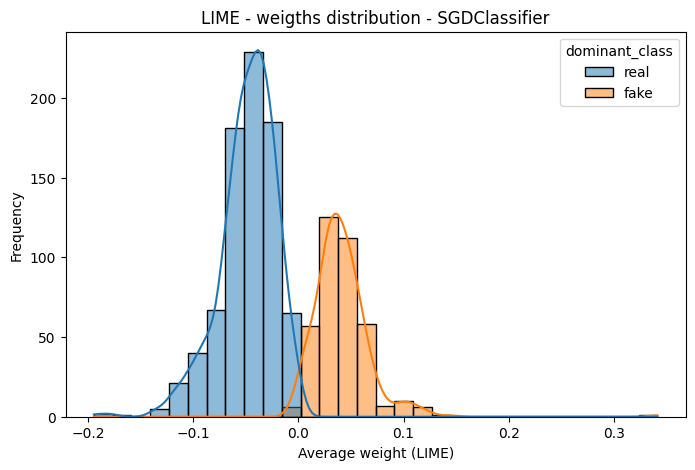


Top 10 most explicative words for Fake (SGDClassifier)


,word,avg_weight,n_occurrences
6880,___________________,0.341681,2
6670,Maria,0.143418,1
6662,Maior,0.122885,1
6893,acertou,0.119103,1
6770,QUE,0.119098,13
7551,votarem,0.117087,1
7335,padre,0.109638,2
6668,Marcelo,0.109565,2
7366,petistas,0.105873,1
7173,fraude,0.105025,2



Top 10 most explicative words for REAL (SGDClassifier)


,word,avg_weight,n_occurrences
7093,eleitorado,-0.194686,1
7459,sentiu,-0.184734,1
7484,suspende,-0.176575,1
7034,coragem,-0.139489,2
7188,globo,-0.134833,1
7454,seja,-0.133530,1
6816,Senhor,-0.132724,1
6504,Carreata,-0.125970,1
6938,argumentos,-0.122644,1
7522,tô,-0.122401,1


In [36]:
def explain_with_lime(model, vectorizer, texts, idx):
    explainer = LimeTextExplainer(class_names=["real", "fake"])

    # checking if texts is a pandas series or a python list
    if hasattr(texts,"iloc"):
      text_instance = texts.iloc[idx]
    else:
      text_instance = texts[idx]

    def predict_proba(texts_list):
        X = vectorizer.transform(texts_list)  # for the texts_test
        if hasattr(model,"predict_proba"):  # checking if the model has "predict_proba" attribute
            return model.predict_proba(X)
        else:
            scores = model.decision_function(X)
            if scores.ndim == 1:
                scores = np.vstack([-scores, scores]).T
            probs = np.exp(scores) / np.exp(scores).sum(axis=1, keepdims=True)
            return probs

    exp = explainer.explain_instance(text_instance, predict_proba, num_features=10)
    return exp.as_list()  # return the list [(word,weight)]



def generate_lime_explanations(trained_models, vectorizer, texts, n_samples=300):
    results = []

    for name, model_tuple in trained_models.items():
        if isinstance(model_tuple,tuple):
          model = model_tuple[0]
        else:
          model = model_tuple

        if not hasattr(model,"predict_proba") and not hasattr(model,"decision_function"):
            print(f"{name} doesn´t support LIME (no probability or decision_function).")
            continue

        print(f"\nGenerating LIME explanations for: {name}")
        for i in tqdm(range(min(n_samples, len(texts)))):
            try:
                exp = explain_with_lime(model,vectorizer,texts,i)
                # {'model':'model_name','word':'word1','weight':weight1,'sample_idx':index,'dominant_class':'class (fake or real)'}
                for word,weight in exp:
                    results.append({
                        "model": name,
                        "word": word,
                        "weight": weight,
                        "sample_idx": i,
                        "dominant_class": "fake" if weight > 0 else "real"
                    })
            except Exception as e:
                print(f"Error on {name} in sample {i}: {e}")

    return pd.DataFrame(results)



def aggregate_word_influence(df):
    agg = (
        df.groupby(["model","word","dominant_class"])
          .agg(avg_weight=("weight","mean"),
               avg_abs_weight=("weight",lambda x: np.mean(np.abs(x))),
               n_occurrences=("weight","count"))
          .reset_index()
    )
    return agg



def plot_weight_distribution(agg_df, model_name):
    subset = agg_df[agg_df["model"] == model_name]
    plt.figure(figsize=(8,5))
    sns.histplot(data=subset, x="avg_weight", hue="dominant_class", bins=30, kde=True)
    plt.title(f"LIME - weigths distribution - {model_name}")
    plt.xlabel("Average weight (LIME)")
    plt.ylabel("Frequency")
    plt.show()


def show_top_words(agg_df, model_name, top_n=10):
    subset = agg_df[agg_df["model"] == model_name]
    top_fake = subset[subset["dominant_class"] == "fake"].nlargest(top_n, "avg_abs_weight")
    top_real = subset[subset["dominant_class"] == "real"].nlargest(top_n, "avg_abs_weight")

    print(f"\nTop {top_n} most explicative words for Fake ({model_name})")
    display(top_fake[["word", "avg_weight", "n_occurrences"]])

    print(f"\nTop {top_n} most explicative words for REAL ({model_name})")
    display(top_real[["word", "avg_weight", "n_occurrences"]])



lime_df = generate_lime_explanations(trained_models, vectorizer, texts_test, n_samples=300)
agg_df = aggregate_word_influence(lime_df)

agg_df.to_csv("lime_global_results.csv", index=False)
print("\nLIME results saved.")

for model_name in agg_df["model"].unique():
    plot_weight_distribution(agg_df, model_name)
    show_top_words(agg_df, model_name, top_n=10)


- Only for MNB,LSVM and SGD

In [37]:
best_models = ["MultinomialNB","LinearSVC","SGDClassifier"]

subset = agg_df[agg_df["model"].isin(best_models)]

for model_name in best_models:
    model_df = subset[subset["model"] == model_name]

    # Top 10 Fake words (positive weights)
    top_fake = (
        model_df[model_df["dominant_class"] == "fake"]
        .nlargest(10, "avg_abs_weight")
    )

    # Top 10 Real words (negative weights)
    top_real = (
        model_df[model_df["dominant_class"] == "real"]
        .nlargest(10, "avg_abs_weight")
    )

    print(f"\nModel: {model_name}")
    print("Top 10 words (FAKE):")
    display(top_fake[["word","avg_weight","n_occurrences"]])

    print("Top 10 words (REAL):")
    display(top_real[["word","avg_weight","n_occurrences"]])



Model: MultinomialNB
Top 10 words (FAKE):


,word,avg_weight,n_occurrences
4502,___________________,0.148494,2
4510,acertou,0.068692,1
4257,Maria,0.066254,1
5068,padre,0.064121,2
4127,Escândalo,0.063614,1
5060,online,0.062302,1
4458,Trump,0.060235,1
5132,prefiro,0.053165,2
4494,Vote,0.052454,3
4252,Maior,0.052048,1


Top 10 words (REAL):


,word,avg_weight,n_occurrences
4047,Carreata,-0.088282,1
4295,O,-0.077207,1
4767,eleitorado,-0.072166,1
5256,suspende,-0.071875,1
5225,sentiu,-0.070059,1
5299,tô,-0.065230,1
4192,Hotel,-0.063579,1
4784,entrar,-0.063575,6
4083,Dep,-0.061734,2
5341,válidos,-0.061499,1



Model: LinearSVC
Top 10 words (FAKE):


,word,avg_weight,n_occurrences
2132,___________________,0.299272,2
1933,Maria,0.101971,1
2023,QUE,0.097017,13
1927,Maior,0.086374,1
2794,vídeo,0.085231,18
2785,votarem,0.078147,1
2122,Vote,0.077853,2
2764,veja,0.076919,2
2144,acertou,0.076469,1
2573,padre,0.075659,2


Top 10 words (REAL):


,word,avg_weight,n_occurrences
2335,eleitorado,-0.145308,1
2699,sentiu,-0.140054,1
2720,suspende,-0.119941,1
2279,coragem,-0.105900,2
2067,Senhor,-0.105577,1
1986,PRODUÇÃO,-0.102341,1
2754,tô,-0.102192,1
2424,globo,-0.102074,1
1770,Carreata,-0.101954,1
2695,seja,-0.101565,1



Model: SGDClassifier
Top 10 words (FAKE):


,word,avg_weight,n_occurrences
6880,___________________,0.341681,2
6670,Maria,0.143418,1
6662,Maior,0.122885,1
6893,acertou,0.119103,1
6770,QUE,0.119098,13
7551,votarem,0.117087,1
7335,padre,0.109638,2
6668,Marcelo,0.109565,2
7366,petistas,0.105873,1
7173,fraude,0.105025,2


Top 10 words (REAL):


,word,avg_weight,n_occurrences
7093,eleitorado,-0.194686,1
7459,sentiu,-0.184734,1
7484,suspende,-0.176575,1
7034,coragem,-0.139489,2
7188,globo,-0.134833,1
7454,seja,-0.133530,1
6816,Senhor,-0.132724,1
6504,Carreata,-0.125970,1
6938,argumentos,-0.122644,1
7522,tô,-0.122401,1


In [38]:
best_models = ["MultinomialNB", "LinearSVC", "SGDClassifier"]

subset = agg_df[agg_df["model"].isin(best_models)]

top_fake_words = {}
top_real_words = {}

for model_name in best_models:
    model_df = subset[subset["model"] == model_name]

    top_fake = (
        model_df[model_df["dominant_class"] == "fake"]
        .nlargest(10, "avg_abs_weight")
    )
    top_real = (
        model_df[model_df["dominant_class"] == "real"]
        .nlargest(10, "avg_abs_weight")
    )

    top_fake_words[model_name] = set(top_fake["word"])
    top_real_words[model_name] = set(top_real["word"])

common_fake = set.intersection(*top_fake_words.values())

common_real = set.intersection(*top_real_words.values())

print("Top 10 Fake - Common Words between Models")
print(common_fake if common_fake else "No word in common.","\n")

print("Top 10 real - Common Words between Models")
print(common_real if common_real else "No word in common.")


Top 10 Fake - Common Words between Models
{np.str_('Maria'), np.str_('Maior'), np.str_('acertou'), np.str_('padre'), np.str_('___________________')} 

Top 10 real - Common Words between Models
{np.str_('eleitorado'), np.str_('Carreata'), np.str_('suspende'), np.str_('sentiu'), np.str_('tô')}
